<a href="https://colab.research.google.com/github/Sovit1056/Pytorch_practice/blob/main/04_Pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.4 PyTorch Custom Datasets

We've ued some datasets with pytorch before.

BUt now we will use our own data via: custom datasets.

## Domain Libraries: https://pytorch.org/domains/

Depending on what we are working on:
* Vision: https://docs.pytorch.org/vision/stable/datasets.html#base-classes-for-custom-datasets
* Text :
* Audio
* Recommendation: like in social media plaform
* Different other data
We'll look into the PyTorch domain libraries for existing data loading function and customize data loading function.

**Resources:**
* Book Version: https://www.learnpytorch.io/04_pytorch_custom_datasets/


## What are we going to cover

* Getting a **custom data** with pytorch
* Preaparing and visualizing our data
* **Transforming data** for use with a model
* **Loading custom data** with pre-built function and custom function
* Building computer vision **model**
* Comparing model with and without **Data augmentation**
* **Making prediction** on custom data.

### Things remain to learn

* Code to creat our own **custom data** set.

## 0. Import Libraries and Setting up device-agnostic code

In [66]:
import torch
from torch import nn

# Seetting the device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [67]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## 1. Get Data

* Tutors dataset is a subset of the Food101 dataset.

* Food101 starts 101 different class of food and 1000 images per class (750 training, 250 testing).

* Tutors dataset starts with 3 classes of food and only 10% of the images ( i.e 75 training and 25 testing)

  Why this?

  * When starting out ML project, it's important to try things on small scale and then increase the scale when done.
  * It is to speed up our experiment

### Importing Zip file from Github

In [68]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesnot exist, download and unzip it......
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download data: we can also download in local drive from github and upload without coding tooo.
with open (data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

# Unzip file:

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping the file...")
    zip_ref.extractall(image_path)



data/pizza_steak_sushi directory exists.
Unzipping the file...


In [69]:
# reset our working directory to /content, where your uploads, mounts, and downloaded files are normally accessible

%cd /content


/content


## 2. Data preparation and Data exploration

In [70]:
import os
def walk_through_dir(dir_path):
  # Walking through dir_path returing its contents.
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.


In [71]:
# Setup train and test paths

train_dir = image_path / "train"  # look how to crete the path as from data_path = Path("data/") and image_path = data_path / "pizza_steak_sushi"

test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing the image

We can directly look from the dataset folder.

But let's try to visualize the image using code.
1. Get all of the image path.
2. Pick a random image path through `random.choice()`
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we are working with images, let's open image with Python's PIL (pillow): https://pypi.org/project/pillow/
5. We'll then show image and print metadata.

| **Function / Setting**                      | **Library / Module**            | **Purpose**                                                       | **Controls**                                                                                                 | **Notes**                                                  |
| ------------------------------------------- | ------------------------------- | ----------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------ | ---------------------------------------------------------- |
| `random.seed(seed)`                         | Python built-in `random` module | Sets seed for Python's default pseudo-random number generator.    | Affects `random.random()`, `random.randint()`, `random.shuffle()`, etc.                                      | Does **not** affect NumPy or PyTorch randomness.           |
| `np.random.seed(seed)`                      | NumPy                           | Sets seed for NumPy's PRNG.                                       | Controls NumPy functions like `np.random.rand()`, `np.random.randn()`, etc.                                  | Does **not** affect Python `random` or PyTorch randomness. |
| `torch.manual_seed(seed)`                   | PyTorch                         | Sets seed for PyTorch's CPU and general PRNG.                     | Controls PyTorch functions like `torch.rand()`, `torch.randn()`, weight initialization, data shuffling, etc. | Recommended for all PyTorch workflows.                     |
| `torch.cuda.manual_seed(seed)`              | PyTorch CUDA                    | Sets seed for **CUDA PRNG** on current GPU.                       | Controls PyTorch CUDA random operations.                                                                     | Needed for reproducibility in GPU computations.            |
| `torch.cuda.manual_seed_all(seed)`          | PyTorch CUDA (multi-GPU)        | Sets seed for all GPUs.                                           | Controls CUDA randomness across all GPUs in multi-GPU setups.                                                | Use in multi-GPU training.                                 |
| `torch.backends.cudnn.deterministic = True` | PyTorch cuDNN backend           | Forces deterministic algorithms in cuDNN.                         | Makes convolution and similar operations reproducible.                                                       | May slightly reduce training speed.                        |
| `torch.backends.cudnn.benchmark = False`    | PyTorch cuDNN backend           | Disables auto-tuner for selecting fastest convolution algorithms. | Prevents non-deterministic algorithm selection.                                                              | Setting to `False` ensures reproducibility.                |


Random image path: data/pizza_steak_sushi/train/sushi/2980779.jpg
Image class: sushi
Image class path: data/pizza_steak_sushi/train/sushi

Image size: (512, 512)

Image mode: RGB

Image format: JPEG

Image height: 512

Image width: 512

Image info: {'jfif': 257, 'jfif_version': (1, 1), 'dpi': (72, 72), 'jfif_unit': 1, 'jfif_density': (72, 72), 'exif': b'Exif\x00\x00MM\x00*\x00\x00\x00\x08\x00\n\x01\x0f\x00\x02\x00\x00\x00\x06\x00\x00\x00\x86\x01\x10\x00\x02\x00\x00\x00\n\x00\x00\x00\x8c\x01\x1a\x00\x05\x00\x00\x00\x01\x00\x00\x00\x96\x01\x1b\x00\x05\x00\x00\x00\x01\x00\x00\x00\x9e\x01(\x00\x03\x00\x00\x00\x01\x00\x02\x00\x00\x011\x00\x02\x00\x00\x00\x06\x00\x00\x00\xa6\x012\x00\x02\x00\x00\x00\x14\x00\x00\x00\xac\x02\x13\x00\x03\x00\x00\x00\x01\x00\x01\x00\x00\x87i\x00\x04\x00\x00\x00\x01\x00\x00\x00\xc0\x88%\x00\x04\x00\x00\x00\x01\x00\x00\x02F\x00\x00\x00\x00Apple\x00iPhone 4S\x00\x00\x00\x00H\x00\x00\x00\x01\x00\x00\x00H\x00\x00\x00\x016.0.1\x002013:01:10 18:00:52\x00\x00\x18\x82\x9

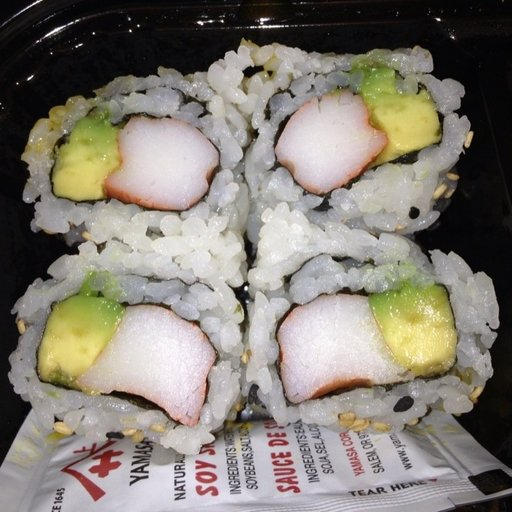

In [72]:
import random
from PIL import Image

#random.seed(42)

# 1. Get all the image path
image_path_list = list(image_path.glob("*/*/*.jpg"))  # 1* is for trian and test / 2* is for pizza, steak and sushi and 3* is for any image file.


# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(f"Random image path: {random_image_path}")

# 3. Get the image class name
image_class = random_image_path.parent.stem   # parent is data/pizza_steak_sushi/train/sushi/ and stem is he end of that folder pizza
print(f"Image class: {image_class}")
print(f"Image class path: {random_image_path.parent}")

# 4. Open image : from the PIL but we can do this from Pytorch also like read
img = Image.open(random_image_path)

# 5. Print metadata
print(f"\nImage size: {img.size}")
print(f"\nImage mode: {img.mode}")
print(f"\nImage format: {img.format}")
print(f'\nImage height: {img.height}')
print(f'\nImage width: {img.width}')
print(f'\nImage info: {img.info}')
print(f"\n Image class: {image_class}")
img



(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

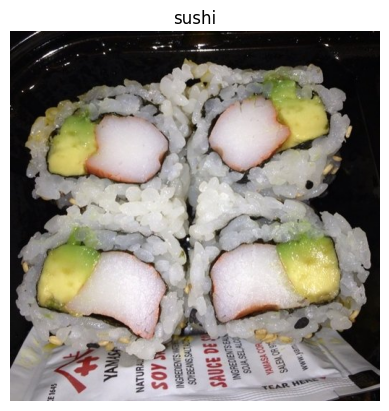

In [73]:
# Visualizing the data with matplotlib

import numpy as np  # to change the image into array
import matplotlib.pyplot as plt

plt.imshow(img)
plt.title(image_class)
plt.axis(False)



(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

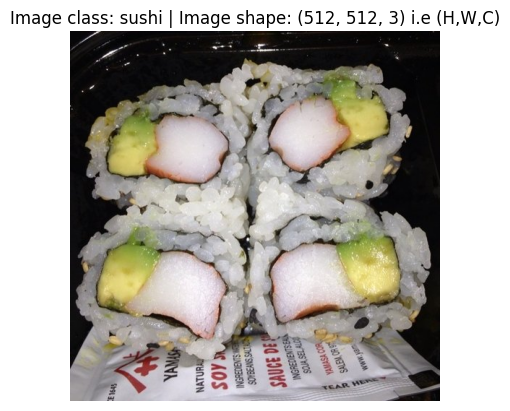

In [74]:
# Trun the image into an numpy array
img_as_array = np.asarray(img)
img_as_array.shape
plt.imshow(img)
plt.title(image_class)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} i.e (H,W,C)")
plt.axis(False)

## 3. Transforming data into tensor

1. Trun our target data into tensor (in this case; numerical representaation of our image)
2. Trun it into a `torch.utils.data.Dataset` and then `torch.utils.data.DataLoader` (i.e iterable or batched version of data set): **Dataset** and **DataLoader**


In [75]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

https://docs.pytorch.org/vision/0.21/transforms.html#:~:text=Transforms%20can%20be%20used%20to,%2C%20segmentation%2C%20video%20classification).&text=Transforms%20are%20typically%20passed%20as,transforms%20argument%20to%20the%20Datasets.

In [76]:
# transforming code

data_transform = transforms.Compose([       # we can also use `torch.nn.squential()`

    # Resize the image into 64 x 64.
    transforms.Resize(size=(64,64)),
    # Flip the images randomly wrt horizontal ( to increase the diversity i.e Data augmentation)
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn image into tensor.
    transforms.ToTensor()    # Convert a PIL Image or ndarray to tensor and scale the values accordingly.
                              #This transform does not support torchscript.
])



In [77]:
data_transform(img)

tensor([[[0.0235, 0.0235, 0.0549,  ..., 0.0196, 0.0314, 0.0314],
         [0.0275, 0.0627, 0.1608,  ..., 0.0196, 0.0235, 0.0196],
         [0.0824, 0.1020, 0.0902,  ..., 0.0392, 0.0431, 0.0431],
         ...,
         [0.6275, 0.6235, 0.6078,  ..., 0.1765, 0.2745, 0.3098],
         [0.6275, 0.6196, 0.6000,  ..., 0.1961, 0.1412, 0.0706],
         [0.6196, 0.6196, 0.6078,  ..., 0.0902, 0.0706, 0.0314]],

        [[0.0235, 0.0235, 0.0471,  ..., 0.0157, 0.0235, 0.0235],
         [0.0275, 0.0627, 0.1569,  ..., 0.0196, 0.0196, 0.0196],
         [0.0745, 0.0941, 0.0824,  ..., 0.0353, 0.0392, 0.0392],
         ...,
         [0.6078, 0.6039, 0.5922,  ..., 0.1647, 0.2510, 0.2902],
         [0.6118, 0.6039, 0.5882,  ..., 0.1804, 0.1255, 0.0627],
         [0.6039, 0.6039, 0.5961,  ..., 0.0588, 0.0510, 0.0314]],

        [[0.0314, 0.0353, 0.0627,  ..., 0.0235, 0.0275, 0.0275],
         [0.0353, 0.0745, 0.1804,  ..., 0.0196, 0.0196, 0.0196],
         [0.0824, 0.1020, 0.0902,  ..., 0.0275, 0.0314, 0.

Transformed image shape: torch.Size([64, 64, 3])
Transformed image shape: torch.Size([64, 64, 3])
Transformed image shape: torch.Size([64, 64, 3])


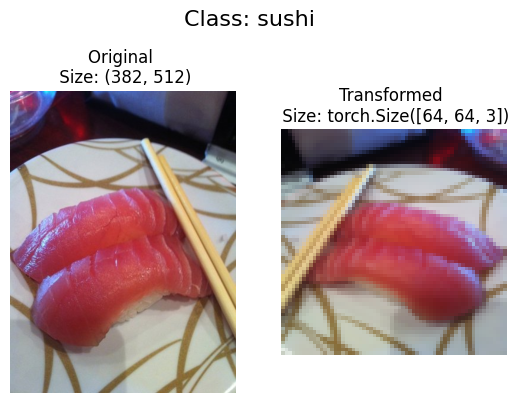

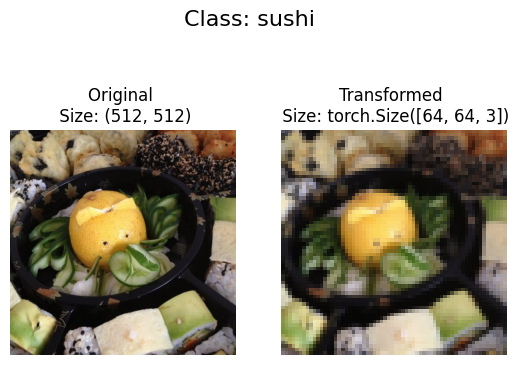

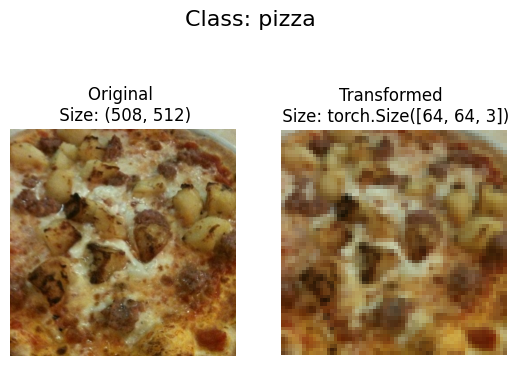

In [78]:
def plot_transform_images(image_paths, transform, n=3, seed= None):  #n=3 define the number of image to be transform at a time
  """
  select random images from a path of images and transform them.
  then plot the original images and the transformed images.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)  ## create the random selection of only 3 image as n=3
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1,2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \n Size: {f.size}")
      ax[0].axis("off")

      # Transform and plot traget image
      transformed_image = transform(f).permute(1,2,0)  ## need to use permute function as matplot.lib only take image in HWC format
      print(f"Transformed image shape: {transformed_image.shape}")  # we can also use transform(f) only.Python looks up what transform refers to → finds it is a Compose object.
                                                                    # Compose has a __call__ method, making it behave like a function.
                                                                    # Thus, calling transform(f) applies all the transformations in order to the input f.
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \n Size: {transformed_image.shape}")
      ax[1].axis(False)    # we can use "off" as above

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize= 16)

plot_transform_images(image_paths = image_path_list,
                      transform = data_transform,
                      n=3,
                      seed= 42)


## 4. Option 1: Loading image data using `Image folder`

We can load image classification data using `torchvision.datasets.ImageFolder`
https://docs.pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html


In [79]:
# Use Imagefolder to create datasets

from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,    # a tranform for the data
                                  target_transform=None)  # a tranform for the label/traget

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

train_data, test_data




(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [80]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [81]:
# Get class names as list
class_names= train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [82]:
# Get class name as dict

class_dict= train_data.class_to_idx
class_dict   # they are used in traget_trasform in above function where do traanform for targeted lable only

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [83]:
# check the length of our datset
len(train_data), len(test_data)

(225, 75)

In [84]:
# if we run to the some labled data we can check that data as:
train_data.samples[10]

('data/pizza_steak_sushi/train/pizza/1572608.jpg', 0)

In [85]:
# Index on the train_data Dataset to get a single image and label
train_data[10]

(tensor([[[0.8235, 0.8000, 0.7961,  ..., 0.8157, 0.8078, 0.8196],
          [0.7843, 0.7961, 0.8353,  ..., 0.8510, 0.8784, 0.8980],
          [0.8471, 0.8902, 0.9412,  ..., 0.9843, 0.9804, 0.9843],
          ...,
          [0.8039, 0.8549, 0.7882,  ..., 0.7882, 0.7529, 0.5412],
          [0.8078, 0.8196, 0.7922,  ..., 0.7176, 0.7608, 0.6784],
          [0.8471, 0.8824, 0.8784,  ..., 0.4902, 0.6627, 0.8196]],
 
         [[0.5882, 0.5686, 0.5647,  ..., 0.5882, 0.5725, 0.5882],
          [0.5333, 0.5569, 0.5961,  ..., 0.6824, 0.6980, 0.7098],
          [0.6039, 0.6549, 0.7059,  ..., 0.8706, 0.8667, 0.8627],
          ...,
          [0.5882, 0.6353, 0.5686,  ..., 0.4980, 0.4745, 0.3412],
          [0.6039, 0.6314, 0.6275,  ..., 0.4549, 0.4745, 0.4431],
          [0.6510, 0.7059, 0.7255,  ..., 0.2980, 0.4118, 0.5451]],
 
         [[0.2706, 0.2549, 0.2510,  ..., 0.3216, 0.3059, 0.3333],
          [0.2431, 0.2471, 0.2588,  ..., 0.4353, 0.4392, 0.4392],
          [0.2745, 0.2941, 0.3176,  ...,

In [86]:
img, label= train_data[10]
img

tensor([[[0.8196, 0.8078, 0.8157,  ..., 0.7961, 0.8000, 0.8235],
         [0.8980, 0.8784, 0.8510,  ..., 0.8353, 0.7961, 0.7843],
         [0.9843, 0.9804, 0.9843,  ..., 0.9412, 0.8902, 0.8471],
         ...,
         [0.5412, 0.7529, 0.7882,  ..., 0.7882, 0.8549, 0.8039],
         [0.6784, 0.7608, 0.7176,  ..., 0.7922, 0.8196, 0.8078],
         [0.8196, 0.6627, 0.4902,  ..., 0.8784, 0.8824, 0.8471]],

        [[0.5882, 0.5725, 0.5882,  ..., 0.5647, 0.5686, 0.5882],
         [0.7098, 0.6980, 0.6824,  ..., 0.5961, 0.5569, 0.5333],
         [0.8627, 0.8667, 0.8706,  ..., 0.7059, 0.6549, 0.6039],
         ...,
         [0.3412, 0.4745, 0.4980,  ..., 0.5686, 0.6353, 0.5882],
         [0.4431, 0.4745, 0.4549,  ..., 0.6275, 0.6314, 0.6039],
         [0.5451, 0.4118, 0.2980,  ..., 0.7255, 0.7059, 0.6510]],

        [[0.3333, 0.3059, 0.3216,  ..., 0.2510, 0.2549, 0.2706],
         [0.4392, 0.4392, 0.4353,  ..., 0.2588, 0.2471, 0.2431],
         [0.5843, 0.5882, 0.6000,  ..., 0.3176, 0.2941, 0.

In [87]:
label

0

In [88]:
class_names[label]

'pizza'

In [89]:
img, label = train_data[0]
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Label: {label}({class_names[label]})")
print(f"Label datatype: {type(label)}")

# Rearrange the order dimensions
img_permuted = img.permute(1,2,0)
print(f"\nImage shape: {img_permuted.shape}")
print(f"Image datatype: {img_permuted.dtype}")

Image shape: torch.Size([3, 64, 64])
Image datatype: torch.float32
Label: 0(pizza)
Label datatype: <class 'int'>

Image shape: torch.Size([64, 64, 3])
Image datatype: torch.float32


### 4.1 Turn loaded data into `DataLoader`

A `DataLoader` is going to help us turn our `Dataset` into iterables and we can customize the `batch_size` so our model can see `batch_size` images at a time.

In [90]:
# Turn train and test datsets into DataLoader's
from torch.utils.data import DataLoader

batch_size = 8
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=batch_size,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=batch_size,
                             num_workers=os.cpu_count(),
                             shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7d1ef2c27650>,
 <torch.utils.data.dataloader.DataLoader at 0x7d1ef2c65cd0>)

In [91]:
len(train_dataloader), len(test_dataloader)

(29, 10)

In [92]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Label shape: {label.shape}")
print(f"Label datatype: {label.dtype}")

Image shape: torch.Size([8, 3, 64, 64])
Image datatype: torch.float32
Label shape: torch.Size([8])
Label datatype: torch.int64


## 5. Option 2: Loading Image Data with a Custom `Dataset`

1. Load image from the file
2. Get class names from the dataset
3. Get classes as dictionary from the datasets.

Pros:
* Can create a `Dataset` out of almost anything.
* Not limited to PyTorch pre-built `Dataset function`

Cons:
* It may not work or function correctly or malfunction.
* Often lead to tremendous coding and leading to error and performance issue.


All custom Datasets in PyTorch, often subclass:  https://docs.pytorch.org/docs/stable/data.html#module-torch.utils.data


In [93]:
import os
import pathlib
import torch

from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset
from typing import List, Tuple, Dict


In [94]:
# Recreating torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a traget directory (the diretory is in standard image classification format)
2. Raise a error if the class name arenot found.
3. trun the class names into a dict and a list and return them.



In [95]:
# Setup path for target directory
traget_directory = train_dir
print(f"Target dir: {traget_directory}")

# Extracting class names
class_names = [entry.name for entry in os.scandir(traget_directory) if entry.is_dir()]
print(f"Class names: {class_names}")

Target dir: data/pizza_steak_sushi/train
Class names: ['sushi', 'pizza', 'steak']


In [96]:
def Class_and_idx(directory:str) -> Tuple[List[str], Dict[str, int]]:

  # 1. Get the class name by scanning the traget directory.
  class_names = sorted(entry.name for entry in os.scandir(traget_directory) if entry.is_dir())

  # 2. Raise an error if class names could not found

  if not class_names:
    raise FileNotFoundError(f"Couldn't find any class name in {traget_directory}.")

  # 3. Creating the dictionary
  class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}

  return class_names, class_to_idx


In [97]:
Class_and_idx(traget_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset`

To create our own custom `Dataset` we need to subclass:

1. subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory also transform (optional)
3. Create several Attributes:
    * paths - paths of our images
    * transform - different transform accordingly
    * classes - a list of the traget classes
    * class_to_idx- a dict
4. Create a function to `load_images()`, function to open image
5. Overwrite the`__len__()` method.
6. Overwrite the `__getitem()__` method to return a given sample when passed an index.

`classtorch.utils.data.Dataset`

An abstract class representing a Dataset.

All datasets that represent a map from keys to data samples should subclass it. All subclasses should overwrite `__getitem__()`, supporting fetching a data sample for a given key. Subclasses could also optionally overwrite `__len__()`, which is expected to return the size of the dataset by many Sampler implementations and the default options of DataLoader. Subclasses could also optionally implement `__getitems__()`, for speedup batched samples loading. This method accepts list of indices of samples of batch and returns list of samples.

In [98]:
# Write a custom dataset class

from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class CustomDataset(Dataset):
  # 2. Inintialize our custom dataset
    def __init__(self,
                 target_dir: str,
                 transform=None):
        # 3. create class attributes
        # get all of image paths
        self.paths = list(pathlib.Path(target_dir).glob("*/*.jpg"))
        # setup transform
        self.transform = transform
        # setup class names
        self.classes, self.class_to_idx = Class_and_idx(target_dir)   # created above

  # 4. Function to load image
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)
  # 5. Overwrite the __len__()
    def __len__(self):
      return len(self.paths)

  # 6. Overwrite the __getitem__() method to return a sample
    def __getitem__(self, index: int) -> Tuple[torch.tensor, int]:
      """ returns one sample of data i.e data and label"""
      img=self.load_image(index)
      class_name = self.paths[index].parent.name  # path in format: data_folder/class_name/image.jpg
      class_idx = self.class_to_idx[class_name]

    # If transform exist
      if self.transform:
        return self.transform(img), class_idx

      else:
        return img, class_idx # return the untransformed dataa


In [99]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [100]:
# Check out CustomDataset with Image folder

train_data_custom = CustomDataset(target_dir=train_dir,
                                  transform=train_transforms)

test_data_custom = CustomDataset(target_dir=test_dir,
                                 transform=test_transforms)

train_data_custom, test_data_custom

(<__main__.CustomDataset at 0x7d1ef2c12690>,
 <__main__.CustomDataset at 0x7d1ef2c274d0>)

In [101]:
train_data

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [102]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [103]:
len(train_data), len(test_data)

(225, 75)

In [104]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [105]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [106]:
train_data_custom.paths[:5]

[PosixPath('data/pizza_steak_sushi/train/sushi/686426.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2017378.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/3360207.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/169392.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/765684.jpg')]

### 5.3 Function to display random images from custom data

1. Function to Input `Dataset` and other parameters: class names, etc. and visualize
2. Display limited number of images. (to prevent display too many images for instance 10)
3. Set seed for reproducibility.
4. Get a list of random sample indexes from the traget dataset.
5. Plot the images.
6. loop through the random sample indexes and plot the images.

In [107]:
# 1. Creating a function
def plot_random_image(dataset: torch.utils.data.Dataset,
                      classes: List[str] = None,
                      n: int = 10,
                      display_shape: bool = True,
                      seed: int = None):

  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print("For display purpose, only 10 images are shown without shape")

  # 3. Set the seeds
  if seed:
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n) # Corrected: k=n is for random.sample

  # 5. Create a figure with subplots
  plt.figure(figsize=(16, 8)) # Adjust figure size as needed

  # 6. Loop and plot through random sample index
  for i, idx in enumerate(random_samples_idx):
    img, label = dataset[idx]

    # Plot samples:
    plt.subplot(1, n, i + 1) # Create subplot for each image
    plt.imshow(img.permute(1, 2, 0))

    # Add details to the plot
    if classes:
        title = f"Class: {classes[label]}"
        if display_shape:
            title += f"\nshape: {img.shape}"
        plt.title(title)
    plt.axis("off")

  plt.tight_layout() # Adjust layout to prevent titles overlapping
  plt.show() # Display the figure with all subplots

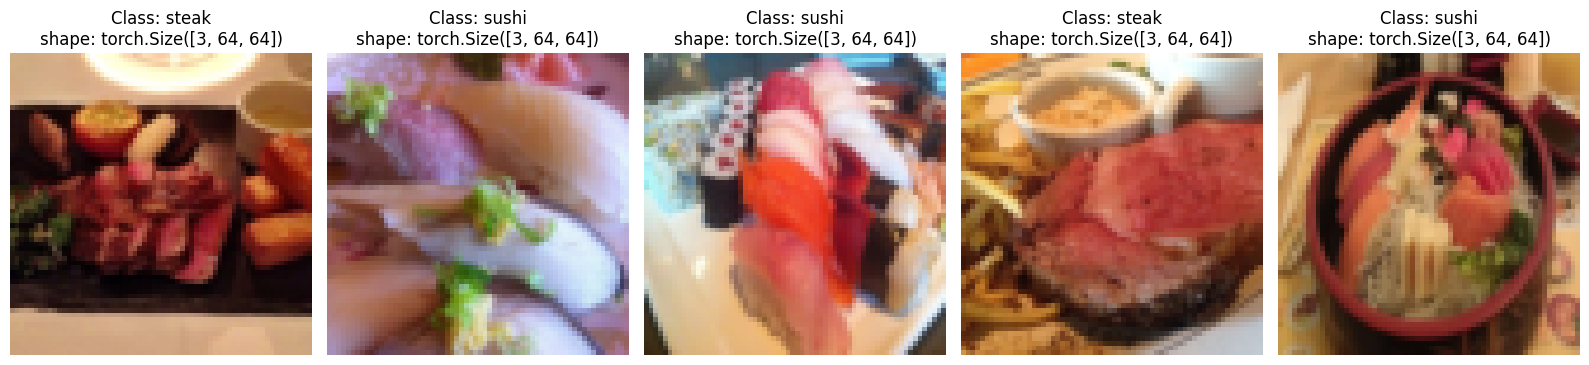

In [108]:
# Display random image from plot_random_image

plot_random_image(dataset=train_data_custom,
                  classes=train_data_custom.classes,
                  n=5,
                  seed=42)

For display purpose, only 10 images are shown without shape


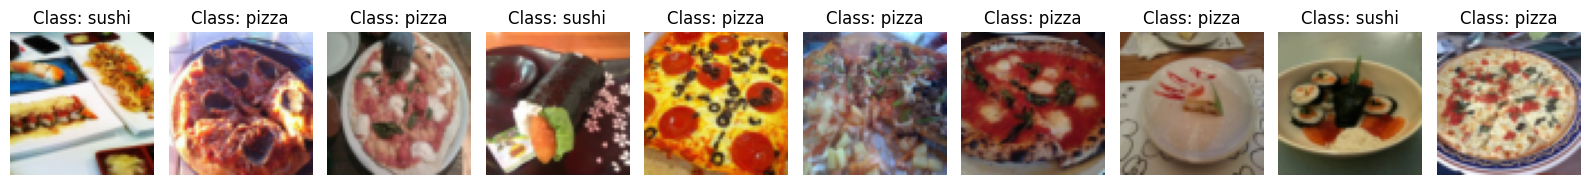

In [109]:
plot_random_image(dataset=train_data,
                  classes=train_data.classes,
                  n=15,
                  seed=42)

### 5.4 Turn custom loaded data into DataLoader

In [110]:
# Turn custom train and test datsets into DataLoader's
from torch.utils.data import DataLoader

batch_size = 8
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                              batch_size=batch_size,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                             batch_size=batch_size,
                             num_workers=os.cpu_count(),
                             shuffle=False)
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7d1ef374b690>,
 <torch.utils.data.dataloader.DataLoader at 0x7d1ef2c27fd0>)

In [111]:
img, label = next(iter(train_dataloader_custom))

print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Label shape: {label.shape}")
print(f"Label datatype: {label.dtype}")

Image shape: torch.Size([8, 3, 64, 64])
Image datatype: torch.float32
Label shape: torch.Size([8])
Label datatype: torch.int64


## 6. Data Augmentation
Data augmentation in deep learning is a technique to artificially increase the size and diversity of a training dataset by applying various transformations to existing data. This helps improve model performance, particularly when dealing with limited or imbalanced datasets, and reduces overfitting.

In our case of image data, this involve image transformation:
*  Rotate – rotating images by certain degrees (e.g. -20° to +20°)
* Shift – translating images horizontally or vertically (e.g. shifting 10% right)
* Zoom – zooming in or out (changing scale)
* Crop – selecting a portion of the image (center or random crop)
* Replace – replacing certain parts (e.g. CutMix, MixUp, or replacing backgrounds)
* Shear – slanting the image along x or y axis (shearing effect)
* Flip – horizontally or vertically
* Brightness/Contrast change – adjusting illumination
* Noise addition – adding random noise to images
* Normalization – scaling pixel values to a fixed range (e.g. 0–1 or standardizing to mean 0, std 1)
* others


Machine learning is all about harnessing the power of randomness and research shows that random transforms (like `transforms.RandAugment()` and `transforms.TrivialAugmentWide()`) generally perform better than hand-picked transforms.

Their are different data augmentation to train our PyTorch vision model to State of the art (SOTA):

Blog post: https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

Here, we will be focusing on TrivialAugment i.e `transforms.TrivialAugmentWide()`

TrivialAugmentWide applies one random image augmentation (like rotate, shear, or adjust brightness) with a random strength each time, to make your model more robust without any complex tuning.

* One random operation: it might pick rotate this time.
* Random magnitude: it might randomly choose +12° rotation this time.
* Simple and effective

Similarly,

| Operation             | Example                   |
| --------------------- | ------------------------- |
| **Shear**             | Shear x by +10°           |
| **Translate**         | Shift right by 15%        |
| **Posterize**         | Reduce to 4 bits/channel  |
| **Solarize**          | Threshold at 128          |
| **Equalize**          | Adjust histogram contrast |
| **Invert**            | Swap black ↔ white        |
| **Adjust Brightness** | +30% brighter             |
| **Adjust Contrast**   | -20% contrast             |
| **Adjust Sharpness**  | +50% sharper              |


In [112]:
# Create simple tranform or resizing
simple_tranform= transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])


In [113]:
# Step 2: Load dataset (replace path)
dataset = datasets.ImageFolder(root=image_path, transform=simple_tranform)
loader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=2)

# Step 3: Calculate mean and std
mean = 0.
std = 0.
total_images_count = 0

for images, _ in loader:
    batch_samples = images.size(0)  # Batch size
    images = images.view(batch_samples, images.size(1), -1)  # Reshape to (B, C, H*W)
    mean += images.mean(2).sum(0)   # Mean over H*W, sum over batch
    std += images.std(2).sum(0)     # Std over H*W, sum over batch
    total_images_count += batch_samples

mean /= total_images_count
std /= total_images_count

print(f"Dataset Mean: {mean}")
print(f"Dataset Std: {std}")


Dataset Mean: tensor([0.5347, 0.4175, 0.3248])
Dataset Std: tensor([0.2396, 0.2416, 0.2312])


In [114]:
# Trivial Augmentation: https://docs.pytorch.org/vision/main/generated/torchvision.transforms.TrivialAugmentWide.html

from torchvision import transforms

def train_transforms_tri(Normalize=True):
    transform_list = [
        transforms.Resize((224, 224)),
        transforms.TrivialAugmentWide(num_magnitude_bins=31),
        transforms.ToTensor()
    ]

    if Normalize:
        transform_list.append(
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        )

    return transforms.Compose(transform_list)

# Don't need to perform augmentation on the test data
test_transforms_tri = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

In [115]:
image_path

PosixPath('data/pizza_steak_sushi')

In [116]:
# getting all image path for custom data
image_path_list=list(image_path.glob("*/*/*.jpg"))
image_path_list[:5]


[PosixPath('data/pizza_steak_sushi/train/sushi/686426.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2017378.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/3360207.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/169392.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/765684.jpg')]

Transformed image shape: torch.Size([224, 224, 3])
Transformed image shape: torch.Size([224, 224, 3])
Transformed image shape: torch.Size([224, 224, 3])
Transformed image shape: torch.Size([224, 224, 3])
Transformed image shape: torch.Size([224, 224, 3])


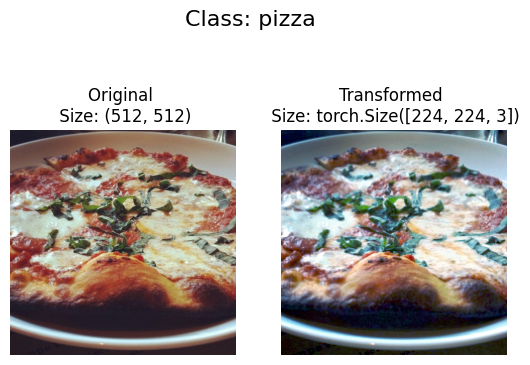

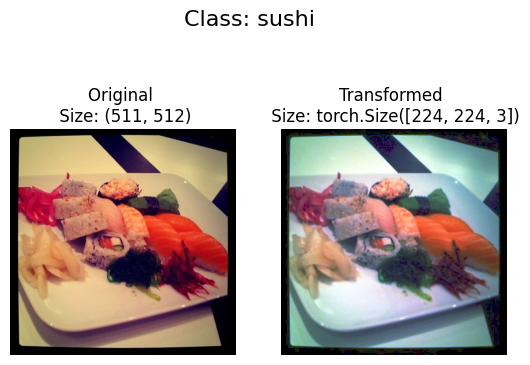

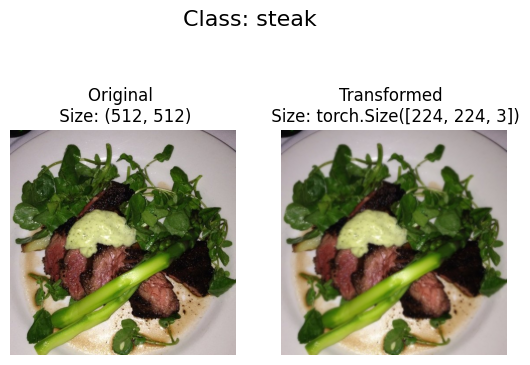

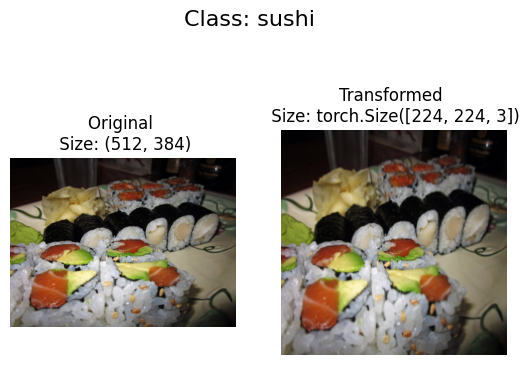

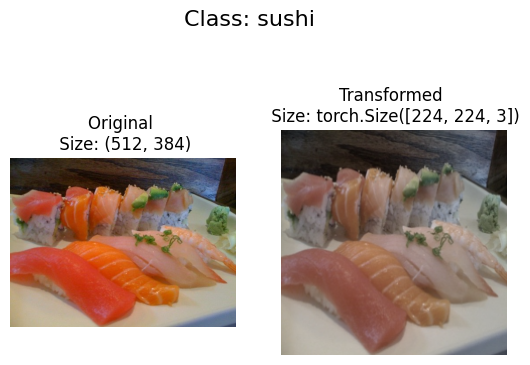

In [117]:
# Plotting random transformed images
plot_transform_images(
    image_paths=image_path_list,
    transform=train_transforms_tri(Normalize=False),
    n=5,
    seed=None
)


## 7. Model 0: TinyVGG without data augmentation

### 7.1 Creating transform and load data

In [118]:
# 1. Load and transform data
from torchvision import datasets

train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform= train_transforms_tri(Normalize=True), # Apply transforms here
                                         target_transform=None)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform= test_transforms_tri) # Apply transforms here

# 2.  Trun the datasets into Dataloaders
import os
from torch.utils.data import DataLoader

# Create Dataloader's
train_data_loader = DataLoader(dataset=train_data_simple,
                               batch_size=8,
                               num_workers=os.cpu_count(),
                               shuffle=True)

test_data_loader = DataLoader(dataset=test_data_simple,
                              batch_size=8,
                              num_workers=os.cpu_count(),
                              shuffle=False)

### 7.2 Creating a model(tinyVGG)

In [119]:
# Create a convolutional neural network

class TinyVGG(nn.Module):

  def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int
                 ):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # defult stride value is same as kernel value
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*53*53,

                      out_features=output_shape)
        )

  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    #print(x.shape)
    return x
    # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benefits from operator fusion: https://horace.io/brrr_intro.html



In [120]:
torch.manual_seed(42)
model_0 = TinyVGG(
    input_shape=3,
    hidden_units= 10,
    output_shape=len(class_names)).to(device)


In [121]:
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=28090, out_features=3, bias=True)
  )
)

### 7.3 Try a foward pass on a single image(to test the model to improve shape of self classifier)

In [122]:
# Get a single image batch
image_batch, label_batch = next(iter(train_data_loader))

# Single image batch
image_single, label_single = image_batch[0].unsqueeze(dim=0), label_batch[0]
image_single.shape, label_single.shape


(torch.Size([1, 3, 224, 224]), torch.Size([]))

In [123]:
# Try a forward pass
model_0(image_single.to(device))

tensor([[ 0.0547,  0.0285, -0.0091]], grad_fn=<AddmmBackward0>)

### 7.4 Use `torch.info` to get a summary and idea of the shapes going through our model

website: https://pypi.org/project/torchinfo/

In [124]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary

model = model_0 # Corrected: Pass the model instance directly
batch_size = 8
summary(model, input_size=[batch_size, 3, 224, 224]) # Changed input_size to use batch_size

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [8, 3]                    --
├─Sequential: 1-1                        [8, 10, 110, 110]         --
│    └─Conv2d: 2-1                       [8, 10, 222, 222]         280
│    └─ReLU: 2-2                         [8, 10, 222, 222]         --
│    └─Conv2d: 2-3                       [8, 10, 220, 220]         910
│    └─ReLU: 2-4                         [8, 10, 220, 220]         --
│    └─MaxPool2d: 2-5                    [8, 10, 110, 110]         --
├─Sequential: 1-2                        [8, 10, 53, 53]           --
│    └─Conv2d: 2-6                       [8, 10, 108, 108]         910
│    └─ReLU: 2-7                         [8, 10, 108, 108]         --
│    └─Conv2d: 2-8                       [8, 10, 106, 106]         910
│    └─ReLU: 2-9                         [8, 10, 106, 106]         --
│    └─MaxPool2d: 2-10                   [8, 10, 53, 53]           --
├─Sequentia

### 7.5 Creating testing and trainnig loop

In [125]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [126]:
# Setup loss_fn/optimizer/accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                            lr=0.001)

# Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',       # Reduce when test_loss doesn't improve
    # factor=0.1,       # Reduce LR by 10x
    patience=3,       # Wait 5 epochs before reducing
    verbose=True      # Print info when LR is reduced
)

In [127]:
# Setup device-agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

# Creating the function for training and testing loop

def training_loop(model: torch.nn.Module,
                  data_loader: torch.utils.data.DataLoader,
                  loss_fn: torch.nn.Module,
                  optimizer: torch.optim.Optimizer,
                  accuracy_fn= accuracy_fn,
                  device: torch.device = device):

  ###Performs a training loop for a PyTorch model.###
  train_loss, train_acc = 0, 0

  # putting model into training mode
  model.train()

  # Loop through the training batches - Removed enumerate
  for X, y in data_loader:

    #Put data on traget device
    X,y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate loss (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()   # accumulate the train loss and avg
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1))

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # print out what is happening
    # Removed batch from the print statement as enumerate is removed
    # if batch % 50 == 0:
      # print(f"Looked at {batch * len(X)}/{len(train_data_loader.dataset)} samples")


  # Divide total train loss by length of train dataloader
  train_loss /= len(data_loader) # Changed train_dataloader to data_loader for generality
  train_acc /= len(data_loader) # Changed train_dataloader to data_loader for generality

  return train_loss, train_acc


def testing_loop(model: torch.nn.Module,
                  data_loader: torch.utils.data.DataLoader,
                  loss_fn: torch.nn.Module,
                  accuracy_fn: accuracy_fn,
                  device: torch.device = device):

  ### Performs a testing loop for a model

  test_loss, test_acc = 0, 0

  # putting into evaluation mode
  model.eval()

  # truning on inference mode context manager
  with torch.inference_mode():
    # Removed enumerate
    for X, y in data_loader:

      # Set the data to the target device
      X, y = X.to(device), y.to(device)

      # Forward pass
      test_pred = model(X)

      # Calculate loss and accuracy
      test_loss += loss_fn(test_pred, y).item()
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1))

    # Calulate loss and accuracy per batches for test data
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

  return test_loss, test_acc

torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn= accuracy_fn):
    ### Returns a dictionary containing the results of model predicting on data_loader

    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X,y in data_loader:

          # Set the data to the target device
            X, y = X.to(device), y.to(device)

            # Make predictions
            y_pred = model(X)


            # Accumulate the loss and acc values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                               y_pred=y_pred.argmax(dim=1))

        # Scle loss and acc to find the average loss/acc per batch

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {model.__class__.__name__: {"model_loss": loss.item(),
                                       "model_acc": acc}}

### 7.6 Creating a single function to make all train and test function together

In [128]:
# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          scheduler,  # new parameter
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          accuracy_fn = accuracy_fn,
          epochs: int = 5,
          device = device):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in range(epochs):
        train_loss, train_acc = training_loop(model=model,
                                           data_loader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer= optimizer,
                                           accuracy_fn=accuracy_fn,
                                           device=device)
        test_loss, test_acc = testing_loop(model=model,
                                          data_loader=test_dataloader,
                                          loss_fn=loss_fn,
                                          accuracy_fn=accuracy_fn,
                                          device=device)


        # 4. Print out what's happening
        if epoch % 5 == 0:
            print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.4f} | "
                f"train_acc: {train_acc:.4f} | "
                f"test_loss: {test_loss:.4f} | "
                f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

        # 🔁 Step scheduler with test loss (important!)
        scheduler.step(test_loss)


    # 6. Return the filled results at the end of the epochs
    return results

In [129]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start = timer()

# Starting a loop
epochs = 50
train(model = model_0,
        train_dataloader= train_data_loader,
        test_dataloader= test_data_loader,
        loss_fn= loss_fn,
        optimizer= optimizer,
        scheduler= scheduler,
        accuracy_fn= accuracy_fn,
        epochs= epochs,
        device= device)
train_time_end = timer()
print(f"Total training time: {train_time_end-train_time_start:.3f} seconds")


Epoch: 1 | train_loss: 1.1672 | train_acc: 39.6552 | test_loss: 1.1435 | test_acc: 35.0000
Epoch: 6 | train_loss: 0.8606 | train_acc: 61.6379 | test_loss: 1.0457 | test_acc: 40.8333
Epoch: 11 | train_loss: 0.6852 | train_acc: 69.3966 | test_loss: 1.0597 | test_acc: 44.5833
Epoch: 16 | train_loss: 0.5851 | train_acc: 74.5690 | test_loss: 1.0207 | test_acc: 48.3333
Epoch: 21 | train_loss: 0.4850 | train_acc: 82.3276 | test_loss: 1.0264 | test_acc: 49.5833
Epoch: 26 | train_loss: 0.5688 | train_acc: 76.2931 | test_loss: 1.0258 | test_acc: 49.5833
Epoch: 31 | train_loss: 0.5561 | train_acc: 79.7414 | test_loss: 1.0257 | test_acc: 49.5833
Epoch: 36 | train_loss: 0.5385 | train_acc: 82.3276 | test_loss: 1.0257 | test_acc: 49.5833
Epoch: 41 | train_loss: 0.5121 | train_acc: 82.3276 | test_loss: 1.0257 | test_acc: 49.5833
Epoch: 46 | train_loss: 0.5071 | train_acc: 80.1724 | test_loss: 1.0257 | test_acc: 49.5833
Total training time: 472.693 seconds
